In [3]:
import os
import subprocess
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt

# Enhanced Sampling Experiments with Learnt CVs

**Systems**: Alanine dipeptide, chignolin. <br>
**CV algorithms**: PCA, tICA, VAMP. <br>
**Baseline comparison**: Literature dihedral angle CVs. <br>
**Enhanced sampling method**: Well-tempered metadynamics. <br>
**Enhanced sampling parameters**: gaussian_height - 1.2, gaussian_pace - every 1ps, bias_factor - 8, sigma - 0.35 (same for every CV). <br>
**Simulation details**: duration - 50ns, stepsize - 2fs, frictioncoeff - 1ps^-1, water - tip3p, precision - mixed, temperature - 300K, nonbondedcutoff - 0.8nm, solventpadding - 1nm, cutoffmethod - CutoffPeriodic, forcefield - amber14, ensemble - NVT. <br>


TODO: script for generating plumed_reweight.dat from plumed.dat

### Utility Scripts

In [16]:
from contextlib import redirect_stdout
from io import StringIO 

class NullIO(StringIO):
    def write(self, txt):
        pass
    
def silent(fn):
    """Decorator to silence functions."""
    def silent_fn(*args, **kwargs):
        with redirect_stdout(NullIO()):
            return fn(*args, **kwargs)
    return silent_fn

In [4]:
def get_fe_grid(data, reweight=False):
    if reweight:
        delta_idx = 1
    else:
        delta_idx = 0
    feature1_traj = data[:, 0+delta_idx]
    feature2_traj = data[:, 1+delta_idx]
    fe = data[:, 2+delta_idx] - np.min(data[:, 2+delta_idx])
    return feature1_traj, feature2_traj, fe

def remove_nans(data: np.array, axis: int = 1) -> np.array:
    num_nans = np.count_nonzero(np.isnan(data))
    if num_nans > 0:
        axis_str = "rows" if axis == 1 else "columns"
        print(f"{num_nans} NaNs detected, removing {axis_str} with NaNs.")
        data = data[~np.isnan(data).any(axis=1), :]

    return data

def init_plot(
    title: Optional[str],
    xlabel: Optional[str],
    ylabel: Optional[str],
    figsize=(6, 4),
    xscale="linear",
    yscale="linear",
    grid_on: bool = False,
    ax=None,
):
    if not ax:
        # If no axis provided, generate one (default)
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(title)
    else:
        fig = None
    ax.set(xscale=xscale, yscale=yscale, xlabel=xlabel, ylabel=ylabel)
    ax.grid(grid_on)

    return fig, ax

In [5]:
def contour_fes(feature1_traj, feature2_traj, bias_potential_traj, xlabel, ylabel, xcorrection, ycorrection, reweight=False):
    feature_traj = np.vstack((feature1_traj, feature2_traj)).T
    xyz = remove_nans(np.hstack([feature_traj, np.array([bias_potential_traj]).T]))
    x = xyz[:, 0]
    y = xyz[:, 1]
    free_energy = xyz[:, 2]
    beta = 0.2 #todo: change
    num_levels = int(
        np.floor((np.max(free_energy) - np.min(free_energy)) * beta)
    )
    levels = [k * 1 / beta for k in range(num_levels + 2)]  # todo: why +2?
    fig, ax = init_plot(xlabel=xlabel, ylabel=ylabel, title='FES')
    if reweight:
        im = ax.contourf(x, y, free_energy, levels=levels, cmap="RdBu_r")
    else:
        im = ax.tricontourf(x, y, free_energy, levels=levels, cmap="RdBu_r")
        ax.tricontour(x, y, free_energy, levels=levels, linewidths=0.5, colors="k")
    ax.set_xlim([-np.pi+xcorrection,np.pi+xcorrection])
    ax.set_ylim([-np.pi+ycorrection,np.pi+ycorrection])

In [26]:
def process_free_energy_surface(directory, xlabel, ylabel, xcorrection, ycorrection, plot=True, reweight=False):      
    HILLS_file = os.path.join(directory, 'HILLS')
    os.chdir(directory)
    # TODO: update kT
    if reweight:
        subprocess.call(f"plumed driver --mf_dcd {directory}/trajectory.dcd --plumed {directory}/plumed_reweight.dat --kt {2.494339}", shell=True, stdout=subprocess.DEVNULL)
        dat_file = os.path.join(directory, 'COLVAR_REWEIGHT')
    else:
        subprocess.call(f"plumed sum_hills --hills {HILLS_file}", shell=True, stdout=subprocess.DEVNULL)
        dat_file = os.path.join(directory, 'fes.dat')
    data = np.genfromtxt(f"{dat_file}", autostrip=True)
    feature1_traj, feature2_traj, fe = get_fe_grid(data, reweight=reweight)
    if plot:
        contour_fes(feature1_traj, feature2_traj, fe, xlabel, ylabel, xcorrection, ycorrection)
        
    return feature1_traj, feature2_traj, fe

In [7]:
def plot_average_fes(directory, xlabel, ylabel, xcorrection , ycorrection):
    for subdirectory_tuple in os.walk(directory):
        subdirs = subdirectory_tuple[1]
        feat1s = []
        feat2s = []
        fes = []
        for subdir in subdirs:
            subdir = os.path.join(directory, subdir)
            feat1, feat2, fe = process_free_energy_surface(subdir, plot=False)
            feat1s.append(feat1)
            feat2s.append(feat2)
            fes.append(fe)

        feat1 = np.concatenate(feat1s)
        feat2 = np.concatenate(feat2s)
        fes = np.concatenate(fes)
        contour_fes(feat1, feat2, fes, xlabel, ylabel, xcorrection, ycorrection)
        break

## About PLUMED Implementation

To implement enhanced sampling correctly in PLUMED raises some challenges. <br>
In particular:
- One has to pay attention to the periodicity of the CVs
- In practice, enhanced sampling along non-ideal CVs seems to make the simulation brittle and ofter run into NaN errors

These issues are highlighted as the crop up in the context of specific simulations below.

To illustrate how brittle these runs can be, all of the following failed after several minutes of simulation:
**ADD**

# Experiment: Alanine Dipeptide

### Baseline FES
50ns with $\phi$ and $\psi$ backbone angles as the CVs <br>
NB: No reweighting required since CVs coincide with dimensions of FES. <br>
phicorrection = --1.4971760511398315 <br>
psicorrection = -1.503533124923706

*PLUMED SCRIPT*
```
RESTART
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 
MATHEVAL ARG=5_7_9_15 FUNC=x--1.4971760511398315 LABEL=PHI_0_ALA_2 PERIODIC=NO 
MATHEVAL ARG=7_9_15_17 FUNC=x-1.503533124923706 LABEL=PSI_0_ALA_2 PERIODIC=NO 
METAD ARG=PHI_0_ALA_2,PSI_0_ALA_2 SIGMA=0.35,0.35 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS PACE=500 LABEL=metad 
PRINT ARG=PHI_0_ALA_2,PSI_0_ALA_2,metad.bias STRIDE=500 FILE=COLVAR 
```

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

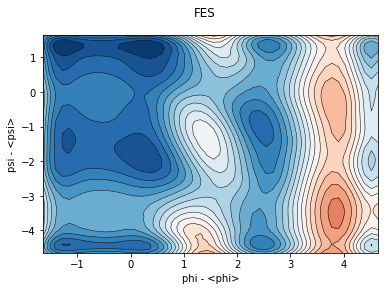

In [38]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/phi_psi_NVT/PHI_0_ALA_2_PSI_0_ALA_2_structure0_repeat_0', xlabel='phi - <phi>', ylabel='psi - <psi>', xcorrection=--1.4971760511398315, ycorrection=-1.503533124923706))

Alternative baseline (~100ns)

*PLUMED SCRIPT*
```
RESTART
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 
CUSTOM ARG=5_7_9_15 FUNC=(x)-0.0 LABEL=DIH_5_7_9_15 PERIODIC=-3.141592653589793,3.141592653589793 
CUSTOM ARG=7_9_15_17 FUNC=(x)-0.0 LABEL=DIH_7_9_15_17 PERIODIC=-3.141592653589793,3.141592653589793 
METAD ARG=DIH_5_7_9_15,DIH_7_9_15_17 SIGMA=0.35,0.35 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS PACE=500 LABEL=metad 
PRINT ARG=DIH_5_7_9_15,DIH_7_9_15_17,metad.bias STRIDE=500 FILE=COLVAR 
```

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

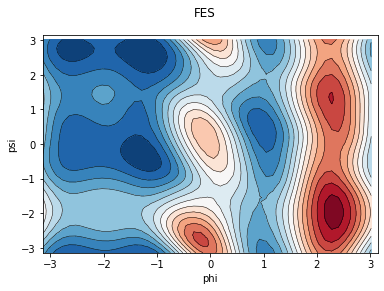

In [39]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/DIH:_ACE_1_C_4_0_-_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0__DIH:_ALA_2_N_6_0_-_ALA_2_CA_8_0_-_ALA_2_C_14_0_-_NME_3_N_16_0__structure0_repeat_0_total_features_4_feature_dimensions_None', xlabel='phi', ylabel='psi', xcorrection=0, ycorrection=0))

### PCA Enhanced Sampling
50ns with:
- $PCA_0 = -0.02 \phi -0.05 \psi - 0.94\theta - 0.33\xi$
- $PCA_1 = 0.01 \phi + 0.01 \psi + 0.33\theta - 0.94\xi$

[total features 4]

Stange that high weights are assigned to $\theta$ and $\xi$ - **TODO check this experiment**.

*PLUMED SCRIPT*
```
RESTART
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 
MATHEVAL ARG=5_7_9_15 FUNC=(x)-0.0 LABEL=DIH_5_7_9_15 PERIODIC=NO 
MATHEVAL ARG=7_9_15_17 FUNC=(x)-0.0 LABEL=DIH_7_9_15_17 PERIODIC=NO 
MATHEVAL ARG=2_5_7_9 FUNC=(x)-0.0 LABEL=DIH_2_5_7_9 PERIODIC=NO 
MATHEVAL ARG=9_15_17_19 FUNC=(x)-0.0 LABEL=DIH_9_15_17_19 PERIODIC=NO 
COMBINE LABEL=PCA:0 ARG=DIH_5_7_9_15,DIH_7_9_15_17,DIH_2_5_7_9,DIH_9_15_17_19 COEFFICIENTS=-0.0205380577990217,-0.054539183881022066,-0.9429486801374994,-0.32779788319997366 PERIODIC=NO 
COMBINE LABEL=PCA:1 ARG=DIH_5_7_9_15,DIH_7_9_15_17,DIH_2_5_7_9,DIH_9_15_17_19 COEFFICIENTS=0.006055704792671213,0.01427230583900042,0.3274622221420084,-0.9447370654289584 PERIODIC=NO 
METAD ARG=PCA:0,PCA:1 SIGMA=0.35,0.35 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS PACE=500 LABEL=metad 
PRINT ARG=PCA:0,PCA:1,metad.bias STRIDE=500 FILE=COLVAR 
```

*REWEIGHTING SCRIPT*
```
RESTART
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 
MATHEVAL ARG=5_7_9_15 FUNC=(x)-0.0 LABEL=DIH_5_7_9_15 PERIODIC=NO 
MATHEVAL ARG=7_9_15_17 FUNC=(x)-0.0 LABEL=DIH_7_9_15_17 PERIODIC=NO 
MATHEVAL ARG=2_5_7_9 FUNC=(x)-0.0 LABEL=DIH_2_5_7_9 PERIODIC=NO 
MATHEVAL ARG=9_15_17_19 FUNC=(x)-0.0 LABEL=DIH_9_15_17_19 PERIODIC=NO 
COMBINE LABEL=PCA:0 ARG=DIH_5_7_9_15,DIH_7_9_15_17,DIH_2_5_7_9,DIH_9_15_17_19 COEFFICIENTS=-0.0205380577990217,-0.054539183881022066,-0.9429486801374994,-0.32779788319997366 PERIODIC=NO 
COMBINE LABEL=PCA:1 ARG=DIH_5_7_9_15,DIH_7_9_15_17,DIH_2_5_7_9,DIH_9_15_17_19 COEFFICIENTS=0.006055704792671213,0.01427230583900042,0.3274622221420084,-0.9447370654289584 PERIODIC=NO 
METAD ARG=PCA:0,PCA:1 SIGMA=0.35,0.35 HEIGHT=0 BIASFACTOR=8 TEMP=300 FILE=HILLS PACE=10000000 LABEL=metad RESTART=YES
PRINT ARG=DIH_5_7_9_15,DIH_7_9_15_17,metad.bias STRIDE=1 FILE=COLVAR_REWEIGHT
# Use the metadynamics bias as argument
as: REWEIGHT_BIAS ARG=PCA:0,PCA:1 
# Calculate histograms of phi and psi dihedrals every 50 steps
# using the weights obtained from the metadynamics bias potentials (umbrella-sampling-like reweighting)
# Look at the manual to understand the parameters of the HISTOGRAM action!
hhphi: HISTOGRAM ARG=DIH_5_7_9_15 STRIDE=50 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=50 BANDWIDTH=0.05 LOGWEIGHTS=as 
hhpsi: HISTOGRAM ARG=DIH_7_9_15_17 STRIDE=50 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=50 BANDWIDTH=0.05 LOGWEIGHTS=as 
# Convert histograms h(s) to free energies F(s) = -kBT * log(h(s))
ffphi: CONVERT_TO_FES GRID=hhphi 
ffpsi: CONVERT_TO_FES GRID=hhpsi 
# Print out the free energies F(s) to file once the entire trajectory is processed
DUMPGRID GRID=ffphi FILE=ffphi.dat 
DUMPGRID GRID=ffpsi FILE=ffpsi.dat 
```

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

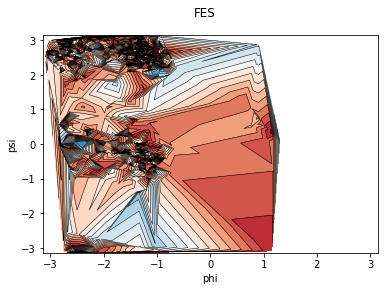

In [37]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/non_periodic/PCA:0_PCA:1_structure0_repeat_0_total_features_4_feature_dimensions_None', xlabel='phi', ylabel='psi', xcorrection=0, ycorrection=0, reweight=True))

[total features 4; kept 2 most "important", which happen to be $\theta$ and $\xi$]

*PLUMED SCRIPT*
```
RESTART
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 
CUSTOM ARG=9_15_17_19 FUNC=(x)-0.09002597630023956 LABEL=DIH_9_15_17_19 PERIODIC=-3.2316186298900327,3.0515666772895536 
CUSTOM ARG=2_5_7_9 FUNC=(x)--0.08674264699220657 LABEL=DIH_2_5_7_9 PERIODIC=-3.0548500065975865,3.2283353005819997 
COMBINE LABEL=PCA:0 ARG=DIH_2_5_7_9,DIH_9_15_17_19 COEFFICIENTS=-0.9448452075742225,-0.32751722660651666 PERIODIC=NO 
COMBINE LABEL=PCA:1 ARG=DIH_9_15_17_19,DIH_2_5_7_9 COEFFICIENTS=-0.944678648086395,0.32799733512585305 PERIODIC=NO 
METAD ARG=PCA:0,PCA:1 SIGMA=0.35,0.35 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS PACE=500 LABEL=metad 
PRINT ARG=PCA:0,PCA:1,metad.bias STRIDE=500 FILE=COLVAR 
```

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

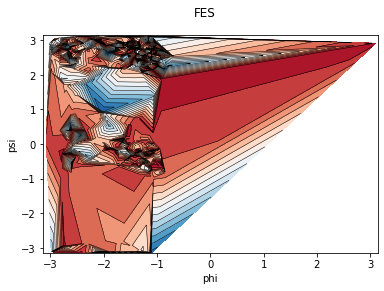

In [42]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_4_feature_dimensions_2', xlabel='phi', ylabel='psi', xcorrection=0, ycorrection=0, reweight=True))

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

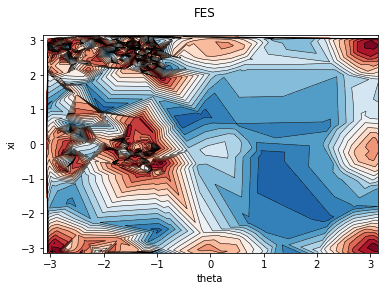

In [43]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_4_feature_dimensions_2', xlabel='theta', ylabel='xi', xcorrection=0, ycorrection=0, reweight=True))

### tICA Enhanced Sampling
50ns with:
- $TICA_0 = -0.67 \phi + 0.74 \psi + 0.03 \theta + 0.00\xi$
- $TICA_1 = 0.97 \phi + 0.26 \psi - 0.00\theta - 0.00\xi$

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

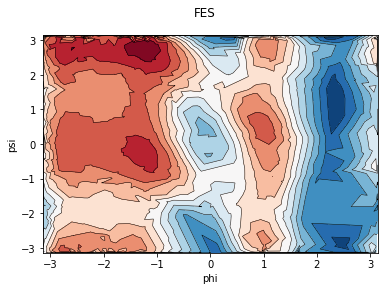

In [35]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/non_periodic/TICA:0_TICA:1_structure0_repeat_0_total_features_4_feature_dimensions_None', xlabel='phi', ylabel='psi', xcorrection=0, ycorrection=0, reweight=True))

### VAMP Enhanced Sampling
50ns with:
- $VAMP_0 = -0.67 \phi + 0.74 \psi + 0.03 \theta + 0.00\xi$
- $VAMP_1 = 0.97 \phi + 0.26 \psi - 0.00\theta - 0.00\xi$

<function __main__.silent.<locals>.silent_fn(*args, **kwargs)>

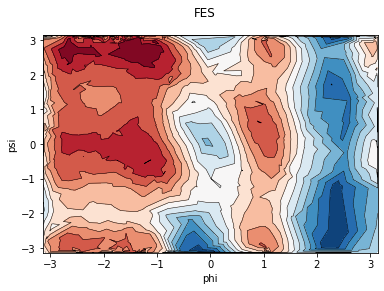

In [36]:
silent(process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/non_periodic/VAMP:0_VAMP:1_structure0_repeat_0_total_features_4_feature_dimensions_None', xlabel='phi', ylabel='psi', xcorrection=0, ycorrection=0, reweight=True))

## Chignolin

In [1]:
from Experiment import Experiment


ModuleNotFoundError: No module named 'Experiment'

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41192   , -5.28856732, -5.16521465, ...,  3.09941465,
         3.22276732,  3.34612   ]),
 array([-3.97203, -3.97203, -3.97203, ...,  4.78602,  4.78602,  4.78602]),
 array([148.82706677, 148.82706677, 148.82706677, ..., 148.82706677,
        148.82706677, 148.82706677]))

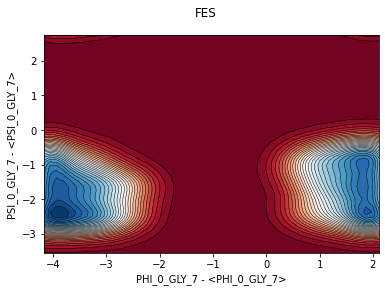

In [6]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure14_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41193   , -5.28857704, -5.16522409, ...,  3.09942408,
         3.22277704,  3.34613   ]),
 array([-3.97203, -3.97203, -3.97203, ...,  4.78602,  4.78602,  4.78602]),
 array([144.81299653, 144.81299653, 144.81299653, ..., 144.81299653,
        144.81299653, 144.81299653]))

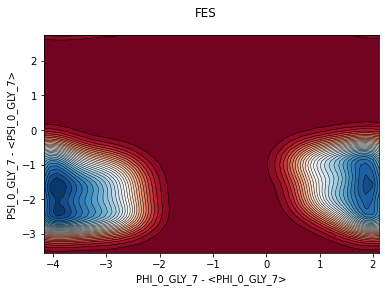

In [7]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure17_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41193   , -5.28857704, -5.16522409, ...,  3.09942408,
         3.22277704,  3.34613   ]),
 array([-3.97201, -3.97201, -3.97201, ...,  4.786  ,  4.786  ,  4.786  ]),
 array([146.52718714, 146.52718714, 146.52718714, ..., 146.52718714,
        146.52718714, 146.52718714]))

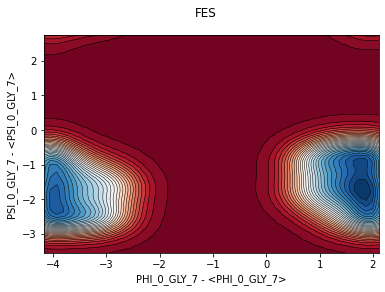

In [8]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure18_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)


## Some incomplete runs

49% complete

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41192   , -5.28856761, -5.16521521, ...,  3.09939521,
         3.22274761,  3.3461    ]),
 array([-3.97204, -3.97204, -3.97204, ...,  4.78601,  4.78601,  4.78601]),
 array([125.01980706, 125.01980706, 125.01980706, ..., 125.01980706,
        125.01980706, 125.01980706]))

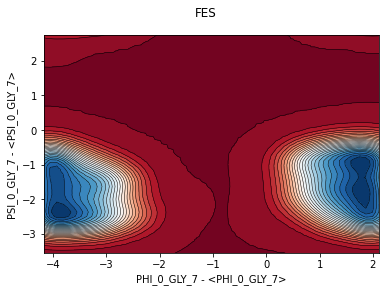

In [9]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure19_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)


33% complete

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41191   , -5.28855747, -5.16520493, ...,  3.09941493,
         3.22276746,  3.34612   ]),
 array([-3.97199, -3.97199, -3.97199, ...,  4.78578,  4.78578,  4.78578]),
 array([124.95908089, 124.95908089, 124.95908089, ..., 124.95908089,
        124.95908089, 124.95908089]))

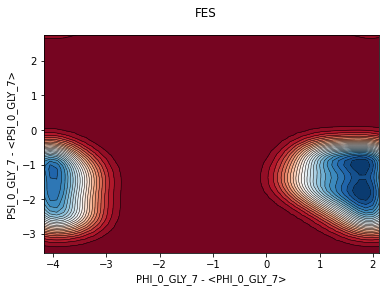

In [11]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure1_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)
